## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

---

# 1. Подготовка

### Импортируем необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Загружаем данные

Указываем **index_col=[0]** и **parse_dates=[0]**, чтобы использовать первый столбец в качестве индекса.

In [2]:
#taxi = pd.read_csv('D:/3D Objects/Praktikum/Data/taxi.csv', index_col=[0], parse_dates=[0])
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Датасет состоит из двух столбцов:
- Индекс в формате даты-времени
- Столбец с количеством заказов

Всего 26496 записей, с 1 марта по 31 августа 2018 года.\
Шаг индекса - 10 минут.

Проверим, что все даты расположены в порядке возрастания. Если это не так, изменим порядок.

In [4]:
taxi.index.is_monotonic

True

Изменение порядка не требуется.

**Поскольку необходимо выполнять предсказания с шагом 1 час, выполним ресемплирование:**

In [5]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


#### Можно переходить к анализу.

---

# 2. Анализ

Взглянем на график количества заказов от времени, а также построим скользящее среднее с окном 2 дня:

D:\Programs\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


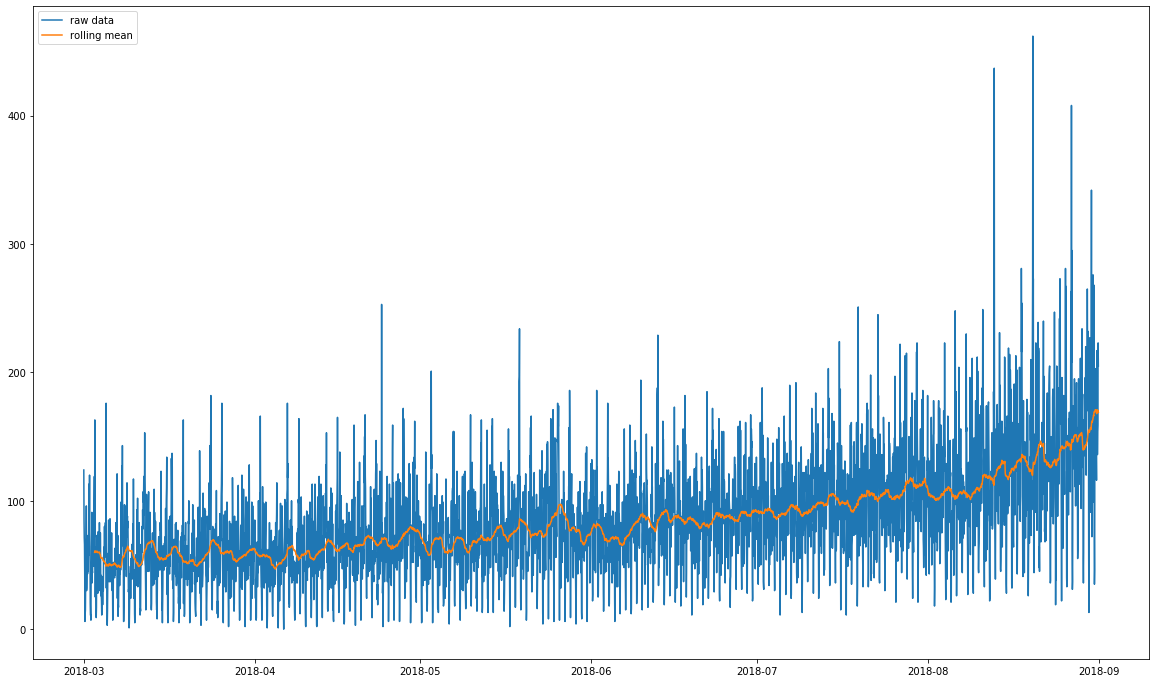

In [6]:
plt.figure(figsize=(20,12))
plt.plot(taxi.index, taxi.num_orders, label='raw data')
plt.plot(taxi.index, taxi.rolling(48).mean(), label='rolling mean')
plt.legend(loc='upper left')

График в данном виде не очень информативен.

Разделим данные на тренды и сезонность методом **seasonal_decompose**.

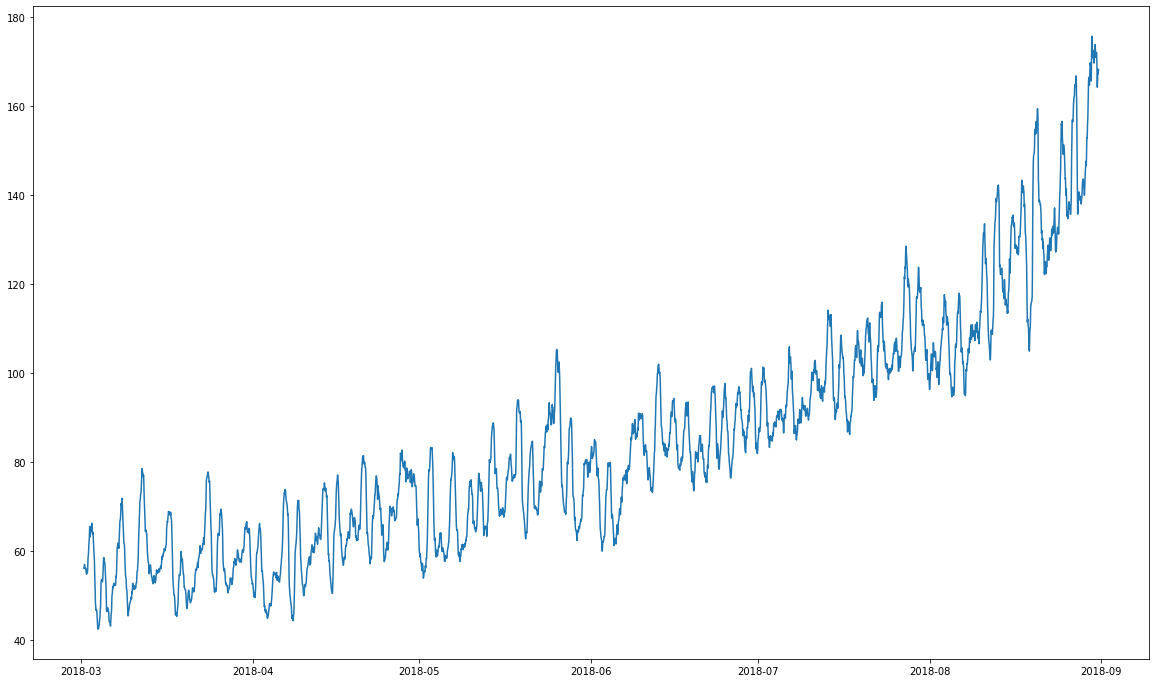

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

taxi_decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(20,12))
plt.plot(taxi.index, taxi_decomposed.trend)

Видим тенденцию к росту количества заказов с марта по август, а также периодические колебания значений внутри каждого месяца.\
Также можем увидеть, что ряд нестационарный.\
Оценим сезонность:

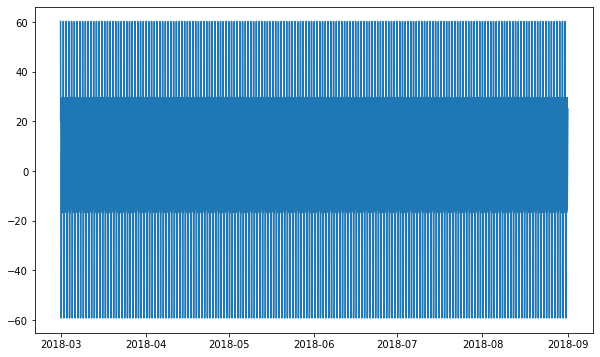

In [8]:
plt.figure(figsize=(10,6))
plt.plot(taxi.index, taxi_decomposed.seasonal)

По графику ничего не понятно, стоит увеличить масштаб:\
**Одна неделя:**

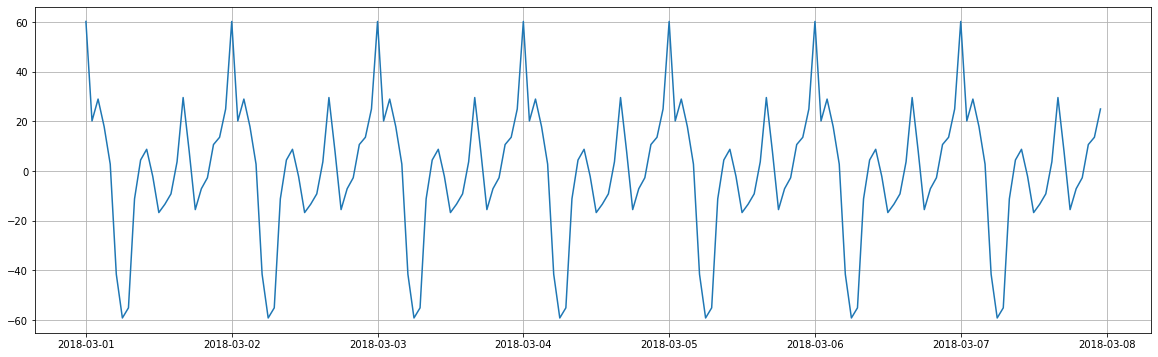

In [9]:
plt.figure(figsize=(20,6))
plt.plot(taxi['2018-03-01':'2018-03-07'].index,
         taxi_decomposed.seasonal['2018-03-01':'2018-03-07'])
plt.grid(True)

**Один день:**

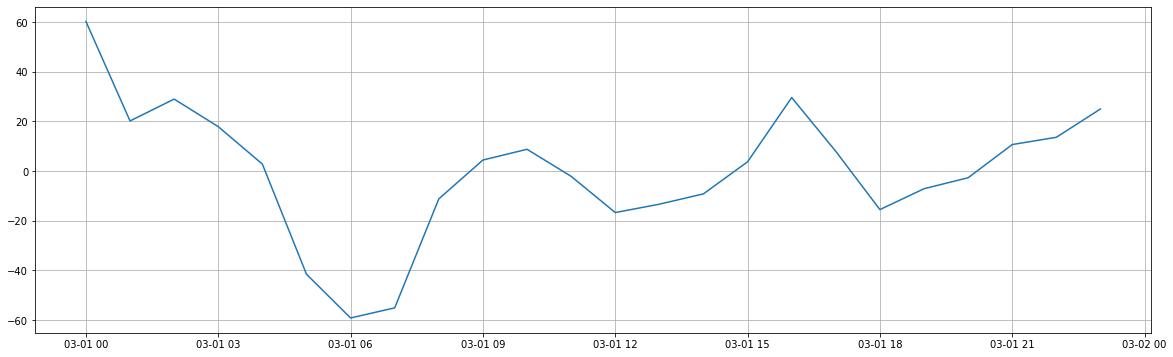

In [10]:
plt.figure(figsize=(20,6))
plt.plot(taxi['2018-03-01':'2018-03-01'].index,
         taxi_decomposed.seasonal['2018-03-01':'2018-03-01'])
plt.grid(True)

### Вывод:

По графику видно, что пик заказов приходится каждый день на полночь, а наименьшее их количество в районе 6 утра.

---

# 3. Обучение

### Перед нами стоит задача регрессии.
Для прогнозирования воспользуемся тремя распространенными моделями:
- **Линейная регрессия**
- **Случайный лес**
- **Градиентный бустинг (LightGBM)**

Для обучения каждой модели потребуется добавить следующие признаки:
- **Номер месяца**
- **День месяца**
- **День недели**
- **Час**
- **"Отстающие" значения**
- **Скользящее среднее**

### Создание признаков

Создадим функцию, добавляющую в данные столбцы с необходимыми признаками.\
В дальнейшем эта функция понадобится при настройке моделей, т.к. позволит выбрать наилучшее значение сдвига и окна для скользящего среднего.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    
    # временные признаки
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # сдвиг
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:,0].shift(lag)
        
    # скользящее среднее
    data['rolling_mean'] = data.iloc[:,0].shift(max_lag).rolling(rolling_mean_size).mean()

In [12]:
make_features(taxi, 4, 6)
taxi.dropna()
taxi.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN


### Разбиение на выборки

Разобьем данные на выборки в соотношении 8:1:1.

In [13]:
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(taxi, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)

# удаляем пропуски, возникшие из-за сдвига
train = train.dropna()

### Функция расчета RMSE

На основе встроенной в **sklearn** функции **MSE** создадим функцию расчета **RMSE**:

In [14]:
from sklearn.metrics import mean_squared_error

def rmse(target, prediction):
    return mean_squared_error(target, prediction)**0.5

# 4. Тестирование

Первым шагом будет создание константной модели, для проверки адекватности моделей, построенных в дальнейшем.

Для этого используем три модели:
- Предсказывающую медианное значение
- Предсказывающую среднее значение
- Предсказывающую предыдущие значения

Valid RMSE median_model 59.68095795210938
Test RMSE median_model 89.39768286346948

Valid RMSE mean_model 58.19705913680892
Test RMSE mean_model 87.62204302292939

Valid RMSE shift_model 59.73573022959834
Test RMSE shift_model 83.32704199479188


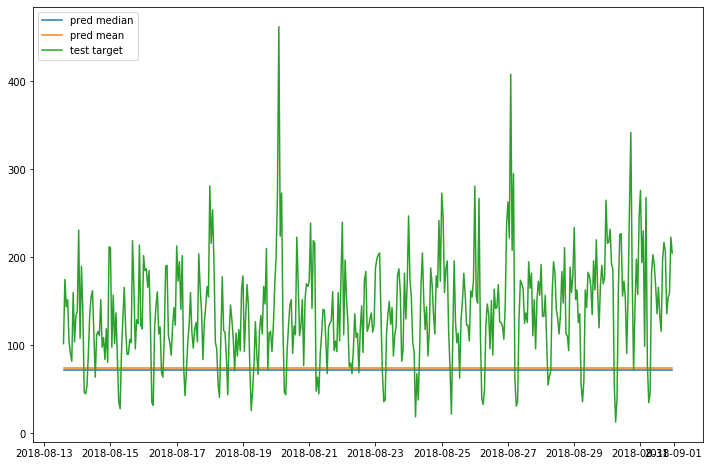

In [33]:
pred_median = pd.Series(train['num_orders'].median(), index=test)
pred_mean = pd.Series(train['num_orders'].mean(), index=test)
pred_shift = pd.Series(train['num_orders'].iloc[-len(test):])

print('Valid RMSE median_model', rmse(valid['num_orders'], pred_median))
print('Test RMSE median_model', rmse(test['num_orders'], pred_median))
print()
print('Valid RMSE mean_model', rmse(valid['num_orders'], pred_mean))
print('Test RMSE mean_model', rmse(test['num_orders'], pred_mean))
print()
print('Valid RMSE shift_model', rmse(valid['num_orders'], pred_shift))
print('Test RMSE shift_model', rmse(test['num_orders'], pred_shift))

# строим графики таргета и константных моделей
# модель, предсказывающую предыдующие значения строить нежелательно,
# поскольку график может стать нечитаемым
plt.figure(figsize=(12, 8))
plt.plot(test.index, pred_median, label='pred median')
plt.plot(test.index, pred_mean, label='pred mean')
plt.plot(test['num_orders'], label='test target')
plt.legend(loc='upper left')

Выходит, **RMSE** проверяемых моделей не должно превышать 58 на валидационной выборке\
и 87 на тестовой.

## Линейная регрессия

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
linear_model = LinearRegression(normalize=True)
linear_model.fit(train.drop(['num_orders'], axis=1), train['num_orders'])

prediction = linear_model.predict(train.drop(['num_orders'], axis=1))
print('Train RMSE linear_model', rmse(train['num_orders'], prediction))

prediction = linear_model.predict(valid.drop(['num_orders'], axis=1))
print('Valid RMSE linear_model', rmse(valid['num_orders'], prediction))

prediction = linear_model.predict(test.drop(['num_orders'], axis=1))
print('Test RMSE linear_model', rmse(test['num_orders'], prediction))

Train RMSE linear_model 29.0124989952803
Valid RMSE linear_model 40.66288816081857
Test RMSE linear_model 53.903132366335704


Получаем 29 на тренировочной выборке, 40 на валидационной и 53 на тестовой.\
Таким образом, модель проходит проверку на адекватность, есть небольшое переобучение.

## Случайный лес

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

Функция для оценки качества (для RandomizedSearchCV):

In [19]:
rmse_score = make_scorer(rmse, greater_is_better=False)

Обучение модели:

In [20]:
%%time

n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]

max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 9, num = 5)]

min_samples_split = [int(x) for x in np.linspace(2, 10, num = 5)]
min_samples_leaf = [int(x) for x in np.linspace(2, 7, num = 4)]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

forest_model = RandomForestRegressor()

forest_random = RandomizedSearchCV(estimator = forest_model,
                                   scoring=rmse_score,
                                   param_distributions = random_grid,
                                   n_iter = 30, cv = 3,
                                   verbose=2, random_state=42, n_jobs = -1)

forest_random.fit(train.drop(['num_orders'], axis=1), train['num_orders'])
forest_random.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   10.2s finished


Wall time: 11.3 s


{'n_estimators': 180,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 9,
 'bootstrap': True}

Сохраняем лучшую модель и оцениваем ее:

In [21]:
forest_model = forest_random.best_estimator_

prediction = forest_model.predict(train.drop(['num_orders'], axis=1))
print('Train RMSE forest_model', rmse(train['num_orders'], prediction))

prediction = forest_model.predict(valid.drop(['num_orders'], axis=1))
print('Valid RMSE forest_model', rmse(valid['num_orders'], prediction))

prediction = forest_model.predict(test.drop(['num_orders'], axis=1))
print('Test RMSE forest_model', rmse(test['num_orders'], prediction))

Train RMSE forest_model 16.842148185010668
Valid RMSE forest_model 33.04024261565765
Test RMSE forest_model 53.57699026039124


Модель случайного леса также проходит проверку на адекватность, хотя результаты и хуже, чем в предыдущем случае.\
Есть переобучение, однако ограничение максимальной глубины дерева и увеличение общего количества деревьев приводит к ухудшению качества предсказаний на валидационной и тестовой выборках.

## Градиентный бустинг (LightGBM)

In [22]:
import lightgbm as lgb

Создадим датасеты LightGBM:

In [23]:
lgb_train = lgb.Dataset(train.drop(['num_orders'], axis=1),
                        train['num_orders'], free_raw_data=False)
lgb_eval = lgb.Dataset(valid.drop(['num_orders'], axis=1),
                        valid['num_orders'], free_raw_data=False)

Подберем параметры и обучим модель:

In [24]:
%%time
params_optimal = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric' : 'mse',
    'learning_rate' : 0.01,
    'feature_fraction' : 0.5,
    'bagging_fraction' : 0.8,
    'bagging_freq' : 2,
    'num_leaves' : 20,
    'max_depth' : 6,
    'max_bin' : 20,
    'min_data_in_leaf' : 3,
}

gbm_model = lgb.train(params_optimal,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=5)

[1]	valid_0's l2: 3357.17
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 3334.83
[3]	valid_0's l2: 3312.25
[4]	valid_0's l2: 3285.04
[5]	valid_0's l2: 3262.95
[6]	valid_0's l2: 3239.97
[7]	valid_0's l2: 3223
[8]	valid_0's l2: 3206.32
[9]	valid_0's l2: 3183.65
[10]	valid_0's l2: 3161.6
[11]	valid_0's l2: 3151.59
[12]	valid_0's l2: 3133.39
[13]	valid_0's l2: 3107.02
[14]	valid_0's l2: 3088.22
[15]	valid_0's l2: 3071.72
[16]	valid_0's l2: 3046.36
[17]	valid_0's l2: 3027.84
[18]	valid_0's l2: 3029.73
[19]	valid_0's l2: 3014.98
[20]	valid_0's l2: 2996.43
[21]	valid_0's l2: 2982.27
[22]	valid_0's l2: 2963.88
[23]	valid_0's l2: 2944.48
[24]	valid_0's l2: 2926.64
[25]	valid_0's l2: 2903.6
[26]	valid_0's l2: 2890.5
[27]	valid_0's l2: 2866.72
[28]	valid_0's l2: 2853.28
[29]	valid_0's l2: 2838.11
[30]	valid_0's l2: 2837.51
[31]	valid_0's l2: 2821.42
[32]	valid_0's l2: 2808.05
[33]	valid_0's l2: 2786.35
[34]	valid_0's l2: 2768.6
[35]	valid_0's l2: 2762.08
[36]	valid_

[396]	valid_0's l2: 1197.01
[397]	valid_0's l2: 1195.98
[398]	valid_0's l2: 1195.79
[399]	valid_0's l2: 1194.8
[400]	valid_0's l2: 1195
[401]	valid_0's l2: 1194
[402]	valid_0's l2: 1192.73
[403]	valid_0's l2: 1191.89
[404]	valid_0's l2: 1192.24
[405]	valid_0's l2: 1191.68
[406]	valid_0's l2: 1189.97
[407]	valid_0's l2: 1187.75
[408]	valid_0's l2: 1187.32
[409]	valid_0's l2: 1186.76
[410]	valid_0's l2: 1186.5
[411]	valid_0's l2: 1185.15
[412]	valid_0's l2: 1182.55
[413]	valid_0's l2: 1181.66
[414]	valid_0's l2: 1181.35
[415]	valid_0's l2: 1180.32
[416]	valid_0's l2: 1179.8
[417]	valid_0's l2: 1177.49
[418]	valid_0's l2: 1176.32
[419]	valid_0's l2: 1175.69
[420]	valid_0's l2: 1173.79
[421]	valid_0's l2: 1172.88
[422]	valid_0's l2: 1172.82
[423]	valid_0's l2: 1171.89
[424]	valid_0's l2: 1170.96
[425]	valid_0's l2: 1171.37
[426]	valid_0's l2: 1171.61
[427]	valid_0's l2: 1171.83
[428]	valid_0's l2: 1171.36
[429]	valid_0's l2: 1171.3
Early stopping, best iteration is:
[424]	valid_0's l2: 117

In [25]:
%%time
prediction = gbm_model.predict(train.drop(['num_orders'], axis=1),
                              num_iteration = gbm_model.best_iteration)
print('Train RMSE gbm_model', rmse(train['num_orders'], prediction))

prediction = gbm_model.predict(valid.drop(['num_orders'], axis=1),
                              num_iteration = gbm_model.best_iteration)
print('Valid RMSE gbm_model', rmse(valid['num_orders'], prediction))

prediction = gbm_model.predict(test.drop(['num_orders'], axis=1),
                              num_iteration = gbm_model.best_iteration)
print('Test RMSE gbm_model', rmse(test['num_orders'], prediction))

Train RMSE gbm_model 19.820915254026218
Valid RMSE gbm_model 34.21928569101049
Test RMSE gbm_model 56.52864687359813
Wall time: 44 ms


Модель показала лучшее качество на валидационной выборке, на тестовой RMSE то же, что и у линейной регрессии.\
Также как и в случае со случайным лесом, присутствует серьезное переобучение.

---

## Предсказание значений тестовой выборки при обучении на объединенных данных обучающей и валидационной выборок.

При разделении моделей на три выборки, в соотношении 8:1:1 временной промежуток между данными для обучения и тестовой выборкой составляет больше месяца.\
Это приводит к тому, что качество предсказания всех моделей на тестовой выборке ниже требуемого значения **RMSE = 48** .

Для корректной проверки на тестовой выборке обучим модели на данных, включающих валидационную выборку, используя оптимальные параметры, которые были выведены ранее.

Создаем новый обучающий датасет, объединив train и valid:

In [26]:
train_valid = train.append(valid)
len(train_valid)

3965

### Линейная регрессия

Train RMSE linear_model 30.497642846207576
Final RMSE linear_model 53.052201458484106


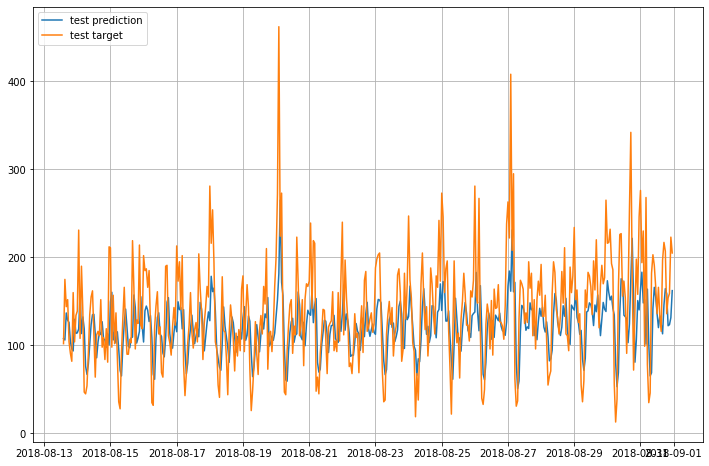

In [27]:
linear_model.fit(train_valid.drop(['num_orders'], axis=1),
                 train_valid['num_orders'])

prediction = linear_model.predict(train_valid.drop(['num_orders'], axis=1))
print('Train RMSE linear_model', rmse(train_valid['num_orders'], prediction))

prediction = linear_model.predict(test.drop(['num_orders'], axis=1))
print('Final RMSE linear_model', rmse(test['num_orders'], prediction))

plt.figure(figsize=(12, 8))
plt.plot(test.index, prediction, label='test prediction')
plt.plot(test['num_orders'], label='test target')
plt.grid(True)
plt.legend(loc='upper left')

### Случайный лес

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.2s finished


Train RMSE forest_model 17.796142556431178
Test RMSE forest_model 46.47514572191969


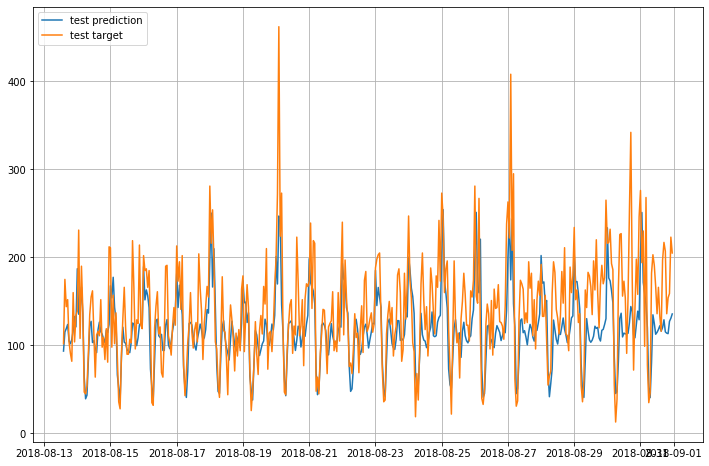

In [28]:
forest_random.fit(train_valid.drop(['num_orders'], axis=1),
                  train_valid['num_orders'])
forest_model = forest_random.best_estimator_

prediction = forest_model.predict(train_valid.drop(['num_orders'], axis=1))
print('Train RMSE forest_model', rmse(train_valid['num_orders'], prediction))

prediction = forest_model.predict(test.drop(['num_orders'], axis=1))
print('Test RMSE forest_model', rmse(test['num_orders'], prediction))

plt.figure(figsize=(12, 8))
plt.plot(test.index, prediction, label='test prediction')
plt.plot(test['num_orders'], label='test target')
plt.grid(True)
plt.legend(loc='upper left')

### Градиентный бустинг

Обновленные датасеты LightGBM:

In [29]:
lgb_train = lgb.Dataset(train_valid.drop(['num_orders'], axis=1),
                        train_valid['num_orders'], free_raw_data=False)
lgb_eval = lgb.Dataset(test.drop(['num_orders'], axis=1),
                        test['num_orders'], free_raw_data=False)

In [30]:
%%time
params_optimal = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric' : 'mse',
    'learning_rate' : 0.01,
    'feature_fraction' : 0.5,
    'bagging_fraction' : 0.8,
    'bagging_freq' : 2,
    'num_leaves' : 20,
    'max_depth' : 6,
    'max_bin' : 20,
    'min_data_in_leaf' : 3,
}

gbm_model = lgb.train(params_optimal,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=5)

[1]	valid_0's l2: 7112.12
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 7064.59
[3]	valid_0's l2: 6983.68
[4]	valid_0's l2: 6927.66
[5]	valid_0's l2: 6886.42
[6]	valid_0's l2: 6829.08
[7]	valid_0's l2: 6780.01
[8]	valid_0's l2: 6691.18
[9]	valid_0's l2: 6638.94
[10]	valid_0's l2: 6591.11
[11]	valid_0's l2: 6535.8
[12]	valid_0's l2: 6492.81
[13]	valid_0's l2: 6437.35
[14]	valid_0's l2: 6391.76
[15]	valid_0's l2: 6338.58
[16]	valid_0's l2: 6285.98
[17]	valid_0's l2: 6219.74
[18]	valid_0's l2: 6203.33
[19]	valid_0's l2: 6164.58
[20]	valid_0's l2: 6129.44
[21]	valid_0's l2: 6100.41
[22]	valid_0's l2: 6070.88
[23]	valid_0's l2: 6039.55
[24]	valid_0's l2: 6009.73
[25]	valid_0's l2: 5969.21
[26]	valid_0's l2: 5940.07
[27]	valid_0's l2: 5900.11
[28]	valid_0's l2: 5853.63
[29]	valid_0's l2: 5810.23
[30]	valid_0's l2: 5797.37
[31]	valid_0's l2: 5756.01
[32]	valid_0's l2: 5710.48
[33]	valid_0's l2: 5675.48
[34]	valid_0's l2: 5641.15
[35]	valid_0's l2: 5625.08
[36]	

[366]	valid_0's l2: 2048.16
[367]	valid_0's l2: 2046.38
[368]	valid_0's l2: 2046.01
[369]	valid_0's l2: 2044.38
[370]	valid_0's l2: 2042.61
[371]	valid_0's l2: 2042.08
[372]	valid_0's l2: 2040.86
[373]	valid_0's l2: 2039.33
[374]	valid_0's l2: 2038.31
[375]	valid_0's l2: 2037.36
[376]	valid_0's l2: 2036.89
[377]	valid_0's l2: 2036.69
[378]	valid_0's l2: 2036.41
[379]	valid_0's l2: 2033.85
[380]	valid_0's l2: 2032.56
[381]	valid_0's l2: 2030.9
[382]	valid_0's l2: 2029.53
[383]	valid_0's l2: 2028.71
[384]	valid_0's l2: 2028.27
[385]	valid_0's l2: 2017.19
[386]	valid_0's l2: 2016.5
[387]	valid_0's l2: 2014.08
[388]	valid_0's l2: 2013.43
[389]	valid_0's l2: 2011.17
[390]	valid_0's l2: 2008.81
[391]	valid_0's l2: 2007.21
[392]	valid_0's l2: 2006.79
[393]	valid_0's l2: 2005.54
[394]	valid_0's l2: 2004.12
[395]	valid_0's l2: 2000.9
[396]	valid_0's l2: 1997.85
[397]	valid_0's l2: 1996.08
[398]	valid_0's l2: 1995.03
[399]	valid_0's l2: 1992.16
[400]	valid_0's l2: 1989.23
[401]	valid_0's l2: 198

Wall time: 377 ms


Train RMSE gbm_model 19.113510893099356
Test RMSE gbm_model 41.807423776875865


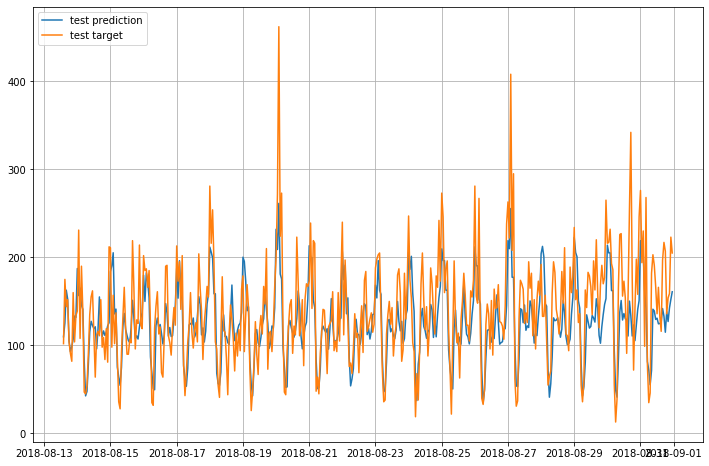

In [31]:
prediction = gbm_model.predict(train_valid.drop(['num_orders'], axis=1),
                              num_iteration = gbm_model.best_iteration)
print('Train RMSE gbm_model', rmse(train_valid['num_orders'], prediction))

prediction = gbm_model.predict(test.drop(['num_orders'], axis=1),
                              num_iteration = gbm_model.best_iteration)
print('Test RMSE gbm_model', rmse(test['num_orders'], prediction))

plt.figure(figsize=(12, 8))
plt.plot(test.index, prediction, label='test prediction')
plt.plot(test['num_orders'], label='test target')
plt.grid(True)
plt.legend(loc='upper left')

---

# 5. Вывод

Из всех рассмотренных моделей наилучшие результаты показала модель **градиентного бустинга (LightGBM)**, получив итоговое **RMSE**:
- **19 на обучающей выборке**
- **41 на тестовой выборке**

Модель **Случайного леса** показала схожий (**21**) результат на обучающей выборке, а **RMSE** на тестовой выборке лишь немного лучше требуемого (**46 при максимуме - 48**).

Обе "лесные" модели при этом значительно переобучились.

**Линейная регрессия** имеет наихудшие показатели **RMSE**, однако все равно лучше константной модели, т.е. проходит проверку на адекватность.

В целом же, не самое высокое качество моделей обусловлено большим интервалом, в котором делаются предсказания (две недели от обучающей выборки).

**При предсказании всего на один час вперед, ошибка будет на порядок меньше.**

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48